In [76]:
import os
import re
from typing import Optional
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Summary of Actions


- The Simulator adds the container to the realm of the Optimizer: 2024-11-14 10:26:30 INFO adding TO TO_CO_TFTU000001, EMT 2024-11-14 10:26:28+01:00
- The Simulator lets your own Vehicle Optimizer run every certain amount of time and the logs show the job sequence per Straddle Carrier per Optimization run:
    - 2024-11-14 10:27:07 INFO SC001 schedule 1:TO_CO_TFTU000018#CO_TFTU000018#PICK,2:TO_CO_TFTU000018#CO_TFTU000018#DROP
    - 2024-11-14 10:27:07 INFO SC002 schedule 1:TO_CO_TFTU000023#CO_TFTU000023#PICK,2:TO_CO_TFTU000023#CO_TFTU000023#DROP

- Additional information regarding what a Straddle Carrier does it listed as follows:
    - 2024-11-14 10:27:07 INFO SC001 starting TO_CO_TFTU000018#CO_TFTU000018#PICK: travel 2024-11-14 10:27:00+01:00
    - 2024-11-14 10:27:30+01:00, action 2024-11-14 10:27:30+01:00 - 2024-11-14 10:28:30+01:00 (to pick up the container, the Straddle Carrier has to travel (30 seconds) and pick up the container (60 seconds).
    - 2024-11-14 10:27:10 INFO SC001 (TO: TO_CO_TFTU000018, CO: CO_TFTU000018, PICK) driving to QC003; 31 s; 172693 mm (Straddle Carrier is driving to a location, driving time and distance is shown – distance is measured in Manhattan Distance)
    - 2024-11-14 10:27:10 DEBUG location QC001: using lane 0 for CO CO_TFTU000001 (shows when a Straddle Carrier is using one of the available and limited spaces in a location)
    - 2024-11-14 10:27:10 INFO SC004 (TO: TO_CO_TFTU000001, CO: CO_TFTU000001, PICK) working at QC001; 60 s (the straddle carrier is picking up the container)
    - 2024-11-14 10:28:07 DEBUG location QC001: freeing lane 0 for CO CO_TFTU000001 (Straddle Carrier has freed up the limited space in a location)
    - 2024-11-14 10:28:07 INFO SC004 (TO: TO_CO_TFTU000001, CO: CO_TFTU000001, PICK) finished at QC001 (Straddle Carrier has finished picking up the container)
    - 2024-11-14 10:28:07 DEBUG finished expected schedule_element TO_CO_TFTU000001#CO_TFTU000001#PICK (Straddle Carrier has finished the logical element of the PICK which we call “schedule_element”)

In [2]:
# Path to data files
data_root_path = "../data"
log_file_path = os.path.join(data_root_path, "logger_all.log")
meta_file_path = os.path.join(data_root_path, "VOSimu-InputInformation.xlsx")

In [3]:
vehicles_meta_df = pd.read_excel("../data/VOSimu-InputInformation.xlsx", sheet_name="Vehicles")
locations_meta_df = pd.read_excel("../data/VOSimu-InputInformation.xlsx", sheet_name="Locations")
co_meta_df = pd.read_excel("../data/VOSimu-InputInformation.xlsx", sheet_name="ContainerOrders")

In [4]:
vehicles_meta_df.rename(columns={"ID": "id", "StartLocation": "start_location", "LogOn": "log_on", "LogOff": "log_off"}, inplace=True)
locations_meta_df.rename(columns={"Location Name": "location", "X-Coordinate [mm]": "x", "Y-Coordinate [mm]": "y", "Capacity limitation (# SC)": "capacity"}, inplace=True)
co_meta_df.rename(columns={"TractorOrderId": "to_id", "ContainerOrderId": "co_id", "ContainerName": "container_name", "Length": "length", "OriginLocation": "origin", "DestinationLocation": "dest", "Time first known": "time_first_known"},
                  inplace=True)

In [5]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Trim all object columns to ensure consistency across tables
    """
    object_cols = df.select_dtypes('object').columns
    df[object_cols] = df[object_cols].apply(lambda x: x.str.strip())
    return df


vehicles_meta_df = preprocess_data(vehicles_meta_df)
locations_meta_df = preprocess_data(locations_meta_df)
co_meta_df = preprocess_data(co_meta_df)

In [6]:
with open(log_file_path, "r") as log_fp:
    log_lines = open(log_file_path, "r").readlines()

In [59]:
### Define the regex patterns for common elements in the logs
datetime_pattern = r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}"
log_level_pattern = r"[A-Z]+"
vehicle_id_pattern = r"SC\d{3}"
to_id_pattern = r"TO_CO_TFTU\d{6}"
co_id_pattern = r"CO_TFTU\d{6}"
vehicle_status_pattern = r"(finished|working|waited)"
action_pattern = r"(PICK|DROP)"
tz_aware_datetime_pattern = r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}[+-]\d{2}:\d{2}"
location_pattern = r"((QC)\d{3}|(RAIL)\d{3}.\d{2,3}|(WS|YARD)\d{3}.\d{2})"
int_pattern = "^-?\d+$"
float_pattern = "^-?\d+(\.\d+)?$"


### Define regex to extract key information from the logs based on certain patterns
log_patterns = {
    "container_submission": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"
        rf"(?P<log_level>{log_level_pattern})\s+"
        rf"adding TO (?P<to_id>{to_id_pattern}),\s+"
        rf"EMT (?P<submission_time>{tz_aware_datetime_pattern})"
    ),
    "schedule": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"
        rf"(?P<log_level>{log_level_pattern})\s+"
        rf"(?P<vehicle_id>{vehicle_id_pattern})\s+"
        rf"schedule\s+(\d:({to_id_pattern})#({co_id_pattern})#({action_pattern}),?)+"
    ),
    "travel_action": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (INFO, ERROR, etc.)
        rf"(?P<vehicle_id>{vehicle_id_pattern})\s+starting\s+"  # Vehicle ID
        rf"(?P<to_id>{to_id_pattern})#"  # TO ID
        rf"(?P<co_id>{co_id_pattern})#"  # CO ID
        rf"(?P<action>{action_pattern}):\s+travel\s+"  # Action type
        rf"(?P<travel_start_time>{tz_aware_datetime_pattern})\s*-\s*"  # Travel start time
        rf"(?P<travel_end_time>{tz_aware_datetime_pattern}),\s*action\s+"  # Travel end time
        rf"(?P<action_start_time>{tz_aware_datetime_pattern})\s*-\s*"  # Action start time
        rf"(?P<action_end_time>{tz_aware_datetime_pattern})"  # Action end time
    ),
    "driving": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (INFO, WARN, etc.)
        rf"(?P<vehicle_id>{vehicle_id_pattern})\s+"  # Vehicle ID
        rf"\(TO:\s+(?P<to_id>{to_id_pattern}),\s+"  # TO ID
        rf"CO:\s+(?P<co_id>{co_id_pattern}),\s+"  # CO ID
        rf"(?P<action>{action_pattern})\)\s+"  # Action type (e.g., PICK, DROP)
        rf"driving to\s+(?P<location_name>{location_pattern});\s+"  # Location name
        rf"(?P<duration_in_s>\d+)\s+s;\s+"  # Duration in seconds
        rf"(?P<distance_in_mm>\d+)\s+mm"  # Distance in millimeters
    ),
    "lane_usage": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (DEBUG, INFO, etc.)
        rf"location\s+(?P<location_name>{location_pattern}):\s+"  # Location name
        rf"(?P<action>(using|freeing))\s+"
        rf"lane\s+(?P<lane_number>\d+)\s+for CO\s+"  # Lane number
        rf"(?P<co_id>{co_id_pattern})"  # CO ID
    ),
    "position_tracking": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"
        rf"(?P<log_level>{log_level_pattern})\s+"
        rf"(?P<vehicle_id>{vehicle_id_pattern}) now at position\s+"
        rf"\((?P<x>\d+),\s+(?P<y>\d+)\)"
    ),
    "action": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (INFO, DEBUG, etc.)
        rf"(?P<vehicle_id>{vehicle_id_pattern})\s+"  # Vehicle ID
        rf"\(TO:\s+(?P<to_id>{to_id_pattern}),\s+"  # TO ID
        rf"CO:\s+(?P<co_id>{co_id_pattern}),\s+"  # CO ID
        rf"(?P<action>{action_pattern})\)\s+"  # Action type (PICK, DROP)
        rf"(?P<status>{vehicle_status_pattern})\s+at\s+"  # Vehicle status (finished, working, waited)
        rf"(?P<location_name>{location_pattern})"  # Location name
        rf"(;\s+(?P<duration_in_s>\d+)\s+s)?"  # Duration in seconds
    ),
    "finish_schedule_element": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (DEBUG, INFO, etc.)
        rf"finished expected schedule_element\s+"  # Fixed phrase
        rf"(?P<to_id>{to_id_pattern})#"  # TO ID
        rf"(?P<co_id>{co_id_pattern})#"  # CO ID
        rf"(?P<action>{action_pattern})"  # Action (PICK, DROP, etc.)
    )
}

def postprocess_parsed_log(raw_log_data: dict) -> dict:
    """
    Post-process extracted data from logs by adjusting data types
    :param raw_log_data: Raw dictionary representing data extracted from a log string
    :return: Post-processed data dictionary of the log
    """
    processed_log = {**raw_log_data}
    for key, value in raw_log_data.items():
        if value is None:
            processed_log[key] = value
        # Parse string date_times to datetime object
        elif re.match(datetime_pattern, value) or re.match(tz_aware_datetime_pattern, value):
            processed_log[key] = datetime.fromisoformat(value).replace(tzinfo=None)
        # Convert numerical strings to integer/float values (in our cases, distances and durations are numerical)
        elif re.match(int_pattern, value):
            processed_log[key] = int(value)
        elif re.match(float_pattern, value):
            processed_log[key] = float(value)
        else:
            processed_log[key] = value
    
    return processed_log

def parse_log(log: str) -> tuple[Optional[str], Optional[dict]]:
    """
    Parse the log string based on regex patterns. If the pattern matches one of the expected patterns, the name of the pattern along with the extracted data from the log will be returned. If the pattern does not match any of those 
    expected, None will be returned
    :param log: A log formatted as string
    :return: (log_pattern, data) if the log matches an expected pattern. Otherwise, (None, None) will be returned.
    """
    log_pattern = None
    extracted_data = None
    for log_pattern_name, regex_compiler in log_patterns.items():
        # Check if the log string matches current regex pattern
        match = regex_compiler.match(log)
        if match:
            # Extract named groups if there's a match
            log_pattern = log_pattern_name
            extracted_data = match.groupdict()
            extracted_data = postprocess_parsed_log(extracted_data)
            if log_pattern == "schedule":
                schedules = re.findall(rf"\d:(?P<to_id>{to_id_pattern})#(?P<co_id>{co_id_pattern})#(?P<action>{action_pattern})", log)
                extracted_data = {
                    **extracted_data,
                    "schedules": schedules
                }

            break

    return log_pattern, extracted_data

In [60]:
relevant_logs = {log_pattern: [] for log_pattern in log_patterns}
parsed_logs = []

for log_line in log_lines:
    pattern, data = parse_log(log_line.strip())
    if pattern:
        relevant_logs[pattern].append(data)
        parsed_logs.append((pattern, data))

In [61]:
for pattern, logs in relevant_logs.items():
    print(pattern, len(logs))

container_submission 286
schedule 8225
travel_action 572
driving 572
lane_usage 968
position_tracking 572
action 1229
finish_schedule_element 572


# Statistical Analyses

In [62]:
position_tracking_df = pd.DataFrame(relevant_logs["position_tracking"])
position_tracking_df[["x", "y"]] = position_tracking_df[["x", "y"]].astype(int)
position_tracking_df = position_tracking_df.merge(locations_meta_df, how="left", on=["x", "y"])
position_tracking_df

,log_time,log_level,vehicle_id,x,y,location,capacity
0,2024-11-14 10:28:07,DEBUG,SC004,242320,993371,QC001,2.0
1,2024-11-14 10:28:07,DEBUG,SC014,342320,993371,QC003,2.0
2,2024-11-14 10:28:09,DEBUG,SC013,342320,993371,QC003,2.0
3,2024-11-14 10:28:34,DEBUG,SC019,541820,993371,QC005,2.0
4,2024-11-14 10:28:38,DEBUG,SC017,541820,993371,QC005,2.0
...,...,...,...,...,...,...,...
567,2024-11-14 11:37:23,DEBUG,SC015,479241,419607,WS013.01,2.0
568,2024-11-14 11:37:48,DEBUG,SC019,642264,993371,QC006,2.0
569,2024-11-14 11:39:02,DEBUG,SC007,479241,419607,WS013.01,2.0
570,2024-11-14 11:39:40,DEBUG,SC016,479241,469607,WS012.01,2.0


In [68]:
travel_action_df = pd.DataFrame(relevant_logs["travel_action"])
travel_action_df["expected_travel_duration"] = (travel_action_df["travel_end_time"] - travel_action_df["travel_start_time"]).dt.total_seconds()
travel_action_df["expected_action_duration"] = (travel_action_df["action_end_time"] - travel_action_df["action_start_time"]).dt.total_seconds()
travel_action_df

,log_time,log_level,vehicle_id,to_id,co_id,action,travel_start_time,travel_end_time,action_start_time,action_end_time,expected_travel_duration,expected_action_duration
0,2024-11-14 10:27:07,INFO,SC001,TO_CO_TFTU000018,CO_TFTU000018,PICK,2024-11-14 10:27:00,2024-11-14 10:27:30,2024-11-14 10:27:30,2024-11-14 10:28:30,30.0,60.0
1,2024-11-14 10:27:07,INFO,SC002,TO_CO_TFTU000023,CO_TFTU000023,PICK,2024-11-14 10:27:00,2024-11-14 10:27:29,2024-11-14 10:27:29,2024-11-14 10:28:29,29.0,60.0
2,2024-11-14 10:27:07,INFO,SC003,TO_CO_TFTU000020,CO_TFTU000020,PICK,2024-11-14 10:27:00,2024-11-14 10:27:27,2024-11-14 10:27:27,2024-11-14 10:28:27,27.0,60.0
3,2024-11-14 10:27:07,INFO,SC004,TO_CO_TFTU000001,CO_TFTU000001,PICK,2024-11-14 10:27:00,2024-11-14 10:27:07,2024-11-14 10:27:07,2024-11-14 10:28:07,7.0,60.0
4,2024-11-14 10:27:07,INFO,SC005,TO_CO_TFTU000019,CO_TFTU000019,PICK,2024-11-14 10:27:00,2024-11-14 10:27:23,2024-11-14 10:27:23,2024-11-14 10:28:23,23.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...
567,2024-11-14 11:34:10,INFO,SC015,TO_CO_TFTU000274,CO_TFTU000274,DROP,2024-11-14 11:38:59,2024-11-14 11:41:11,2024-11-14 11:41:11,2024-11-14 11:42:11,132.0,60.0
568,2024-11-14 11:35:29,INFO,SC019,TO_CO_TFTU000281,CO_TFTU000281,PICK,2024-11-14 11:40:19,2024-11-14 11:41:37,2024-11-14 11:41:37,2024-11-14 11:42:37,78.0,60.0
569,2024-11-14 11:35:49,INFO,SC007,TO_CO_TFTU000269,CO_TFTU000269,DROP,2024-11-14 11:40:39,2024-11-14 11:42:51,2024-11-14 11:42:51,2024-11-14 11:43:51,132.0,60.0
570,2024-11-14 11:36:54,INFO,SC016,TO_CO_TFTU000285,CO_TFTU000285,DROP,2024-11-14 11:41:49,2024-11-14 11:43:34,2024-11-14 11:43:34,2024-11-14 11:44:34,105.0,60.0


In [69]:
driving_df = pd.DataFrame(relevant_logs["driving"]).rename(columns={"duration_in_s": "driving_time"})
driving_df[["driving_time", "distance_in_mm"]] = driving_df[["driving_time", "distance_in_mm"]].astype(int)
driving_df

,log_time,log_level,vehicle_id,to_id,co_id,action,location_name,driving_time,distance_in_mm
0,2024-11-14 10:27:10,INFO,SC001,TO_CO_TFTU000018,CO_TFTU000018,PICK,QC003,31,172693
1,2024-11-14 10:27:10,INFO,SC002,TO_CO_TFTU000023,CO_TFTU000023,PICK,QC003,29,162693
2,2024-11-14 10:27:10,INFO,SC003,TO_CO_TFTU000020,CO_TFTU000020,PICK,QC003,27,152693
3,2024-11-14 10:27:10,INFO,SC004,TO_CO_TFTU000001,CO_TFTU000001,PICK,QC001,8,42693
4,2024-11-14 10:27:10,INFO,SC005,TO_CO_TFTU000019,CO_TFTU000019,PICK,QC003,24,132693
...,...,...,...,...,...,...,...,...,...
567,2024-11-14 11:34:10,INFO,SC015,TO_CO_TFTU000274,CO_TFTU000274,DROP,WS013.01,133,736787
568,2024-11-14 11:35:29,INFO,SC019,TO_CO_TFTU000281,CO_TFTU000281,PICK,QC006,79,436787
569,2024-11-14 11:35:49,INFO,SC007,TO_CO_TFTU000269,CO_TFTU000269,DROP,WS013.01,133,736787
570,2024-11-14 11:36:54,INFO,SC016,TO_CO_TFTU000285,CO_TFTU000285,DROP,WS012.01,106,586343


In [70]:
action_df = pd.DataFrame(relevant_logs["action"])
action_df['duration_in_s'] = action_df['duration_in_s'].fillna(0.0).astype(int)
waiting_df = action_df[action_df['status'] == "waited"].rename(columns={"duration_in_s": "waiting_time"})
working_df = action_df[action_df['status'] == "working"].rename(columns={"duration_in_s": "processing_time"})

merged_df = working_df.merge(waiting_df[["co_id", "action", "waiting_time"]], how="left", on=["co_id", "action"]).drop(columns=["status"])
merged_df["waiting_time"] = merged_df["waiting_time"].fillna(0.0)
merged_df

,log_time,log_level,vehicle_id,to_id,co_id,action,location_name,processing_time,waiting_time
0,2024-11-14 10:27:10,INFO,SC004,TO_CO_TFTU000001,CO_TFTU000001,PICK,QC001,60,0.0
1,2024-11-14 10:27:10,INFO,SC014,TO_CO_TFTU000005,CO_TFTU000005,PICK,QC003,60,0.0
2,2024-11-14 10:27:10,INFO,SC013,TO_CO_TFTU000007,CO_TFTU000007,PICK,QC003,60,0.0
3,2024-11-14 10:27:34,INFO,SC019,TO_CO_TFTU000002,CO_TFTU000002,PICK,QC005,60,0.0
4,2024-11-14 10:27:38,INFO,SC017,TO_CO_TFTU000016,CO_TFTU000016,PICK,QC005,60,0.0
...,...,...,...,...,...,...,...,...,...
567,2024-11-14 11:36:23,INFO,SC015,TO_CO_TFTU000274,CO_TFTU000274,DROP,WS013.01,60,0.0
568,2024-11-14 11:36:48,INFO,SC019,TO_CO_TFTU000281,CO_TFTU000281,PICK,QC006,60,0.0
569,2024-11-14 11:38:02,INFO,SC007,TO_CO_TFTU000269,CO_TFTU000269,DROP,WS013.01,60,0.0
570,2024-11-14 11:38:40,INFO,SC016,TO_CO_TFTU000285,CO_TFTU000285,DROP,WS012.01,60,0.0


In [71]:
merged_df = (merged_df
             .merge(driving_df[["to_id", "co_id", "action", "driving_time", "distance_in_mm"]], on=['to_id', 'co_id', 'action'], how='left')
             .merge(travel_action_df[["to_id", "co_id", "action", "expected_travel_duration", "expected_action_duration"]], on=['to_id', 'co_id', 'action'], how='left')
             )
merged_df["total_time_reported"] = merged_df["driving_time"] + merged_df["waiting_time"] + merged_df["processing_time"]
merged_df["total_time_expected"] = merged_df["expected_travel_duration"] + merged_df["expected_action_duration"]
merged_df

,log_time,log_level,vehicle_id,to_id,co_id,action,location_name,processing_time,waiting_time,driving_time,distance_in_mm,expected_travel_duration,expected_action_duration,total_time_reported,total_time_expected
0,2024-11-14 10:27:10,INFO,SC004,TO_CO_TFTU000001,CO_TFTU000001,PICK,QC001,60,0.0,8,42693,7.0,60.0,68.0,67.0
1,2024-11-14 10:27:10,INFO,SC014,TO_CO_TFTU000005,CO_TFTU000005,PICK,QC003,60,0.0,8,42693,7.0,60.0,68.0,67.0
2,2024-11-14 10:27:10,INFO,SC013,TO_CO_TFTU000007,CO_TFTU000007,PICK,QC003,60,0.0,9,52693,9.0,60.0,69.0,69.0
3,2024-11-14 10:27:34,INFO,SC019,TO_CO_TFTU000002,CO_TFTU000002,PICK,QC005,60,0.0,35,192193,34.0,60.0,95.0,94.0
4,2024-11-14 10:27:38,INFO,SC017,TO_CO_TFTU000016,CO_TFTU000016,PICK,QC005,60,0.0,38,212193,38.0,60.0,98.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,2024-11-14 11:36:23,INFO,SC015,TO_CO_TFTU000274,CO_TFTU000274,DROP,WS013.01,60,0.0,133,736787,132.0,60.0,193.0,192.0
568,2024-11-14 11:36:48,INFO,SC019,TO_CO_TFTU000281,CO_TFTU000281,PICK,QC006,60,0.0,79,436787,78.0,60.0,139.0,138.0
569,2024-11-14 11:38:02,INFO,SC007,TO_CO_TFTU000269,CO_TFTU000269,DROP,WS013.01,60,0.0,133,736787,132.0,60.0,193.0,192.0
570,2024-11-14 11:38:40,INFO,SC016,TO_CO_TFTU000285,CO_TFTU000285,DROP,WS012.01,60,0.0,106,586343,105.0,60.0,166.0,165.0


In [72]:
total_duration_estimate_error = (merged_df["total_time_reported"] - merged_df["total_time_expected"]).sum()
avg_waiting_time = merged_df.groupby(["action"])["waiting_time"].mean()
total_distance_traveled = merged_df.groupby("vehicle_id")["distance_in_mm"].sum()

In [73]:
vehicle_location_df = vehicles_meta_df.merge(locations_meta_df, how="left", left_on="start_location", right_on="location")
vehicle_location_df

,id,start_location,log_on,log_off,location,x,y,capacity
0,SC001,YARD001.09,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.09,212302,950696,NaN
1,SC002,YARD001.10,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.10,222302,950696,NaN
2,SC003,YARD001.11,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.11,232302,950696,NaN
3,SC004,YARD001.12,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.12,242302,950696,NaN
4,SC005,YARD001.13,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.13,252302,950696,NaN
5,SC006,YARD001.14,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.14,262302,950696,NaN
6,SC007,YARD001.15,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.15,272302,950696,NaN
7,SC008,YARD001.16,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.16,282302,950696,NaN
8,SC009,YARD001.17,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.17,292302,950696,NaN
9,SC010,YARD001.18,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.18,302302,950696,NaN


In [74]:
co_location_df = (co_meta_df
                  .merge(locations_meta_df, how="left", left_on="origin", right_on="location")
                  .drop(columns=["location", "capacity"])
                  .rename(columns={"x": "origin_x", "y": "origin_y"})
                  .merge(locations_meta_df, how="left", left_on="dest", right_on="location")
                  .drop(columns=["location", "capacity"])
                  .rename(columns={"x": "dest_x", "y": "dest_y"})
                  )
co_location_df

,to_id,co_id,container_name,length,origin,dest,time_first_known,origin_x,origin_y,dest_x,dest_y
0,TO_CO_TFTU000067,CO_TFTU000067,TFTU000067,20,QC005,WS001.01,2024-08-21 07:12:00,541820,993371,479241,919607
1,TO_CO_TFTU000121,CO_TFTU000121,TFTU000121,40,QC003,WS001.01,2024-08-21 07:21:00,342320,993371,479241,919607
2,TO_CO_TFTU000156,CO_TFTU000156,TFTU000156,40,QC006,WS001.01,2024-08-21 07:28:00,642264,993371,479241,919607
3,TO_CO_TFTU000175,CO_TFTU000175,TFTU000175,40,QC003,WS001.01,2024-08-21 07:35:00,342320,993371,479241,919607
4,TO_CO_TFTU000211,CO_TFTU000211,TFTU000211,40,QC005,WS001.01,2024-08-21 07:45:00,541820,993371,479241,919607
...,...,...,...,...,...,...,...,...,...,...,...
281,TO_CO_TFTU000151,CO_TFTU000151,TFTU000151,20,QC006,YARD001.57,2024-08-21 07:27:00,642264,993371,692302,950696
282,TO_CO_TFTU000166,CO_TFTU000166,TFTU000166,20,QC003,YARD001.57,2024-08-21 07:31:00,342320,993371,692302,950696
283,TO_CO_TFTU000059,CO_TFTU000059,TFTU000059,20,QC006,YARD001.58,2024-08-21 07:11:00,642264,993371,702302,950696
284,TO_CO_TFTU000005,CO_TFTU000005,TFTU000005,20,QC003,YARD001.59,2024-08-21 07:01:00,342320,993371,712302,950696


In [19]:
vehicle_travel_df = position_tracking_df.groupby("vehicle_id", as_index=False).agg({"x": lambda x: list(x), "y": lambda y: list(y)})
x, y = vehicle_travel_df.iloc[10]["x"], vehicle_travel_df.iloc[10]["y"]

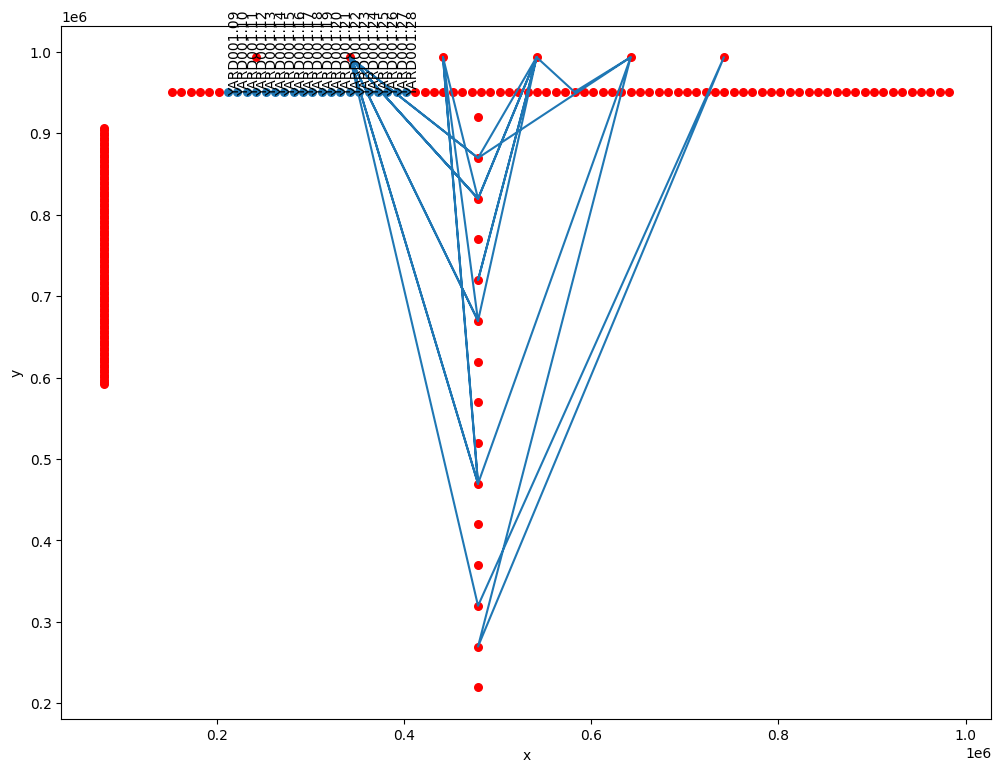

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
vehicle_location_df.plot("x", "y", kind="scatter", s=30, ax=ax)

for i, row in vehicle_location_df.iterrows():
    ax.annotate(row['location'], (row['x'], row['y']), fontsize=10, rotation=90)

remaining_locs_df = locations_meta_df[~locations_meta_df["location"].isin(vehicles_meta_df["start_location"].values)]
remaining_locs_df.plot("x", "y", kind="scatter", ax=ax, c="r", s=30)
plt.plot(x, y)

In [93]:
all_data = []
all_data.extend([parsed_log[1] for parsed_log in parsed_logs])
all_data = pd.DataFrame(all_data)
all_data[(all_data.to_id == "TO_CO_TFTU000001") | (all_data.co_id == "CO_TFTU000001")]

,log_time,log_level,to_id,submission_time,vehicle_id,schedules,co_id,action,travel_start_time,travel_end_time,action_start_time,action_end_time,location_name,duration_in_s,distance_in_mm,lane_number,status,x,y
0,2024-11-14 10:26:30,INFO,TO_CO_TFTU000001,2024-11-14 10:26:28,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,2024-11-14 10:27:07,INFO,TO_CO_TFTU000001,NaT,SC004,NaN,CO_TFTU000001,PICK,2024-11-14 10:27:00,2024-11-14 10:27:07,2024-11-14 10:27:07,2024-11-14 10:28:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2024-11-14 10:27:10,INFO,TO_CO_TFTU000001,NaT,SC004,NaN,CO_TFTU000001,PICK,NaT,NaT,NaT,NaT,QC001,8.0,42693.0,NaN,NaN,NaN,NaN
115,2024-11-14 10:27:10,DEBUG,NaN,NaT,NaN,NaN,CO_TFTU000001,using,NaT,NaT,NaT,NaT,QC001,NaN,NaN,0.0,NaN,NaN,NaN
117,2024-11-14 10:27:10,INFO,TO_CO_TFTU000001,NaT,SC004,NaN,CO_TFTU000001,PICK,NaT,NaT,NaT,NaT,QC001,60.0,NaN,NaN,working,NaN,NaN
255,2024-11-14 10:28:07,DEBUG,NaN,NaT,NaN,NaN,CO_TFTU000001,freeing,NaT,NaT,NaT,NaT,QC001,NaN,NaN,0.0,NaN,NaN,NaN
256,2024-11-14 10:28:07,INFO,TO_CO_TFTU000001,NaT,SC004,NaN,CO_TFTU000001,PICK,NaT,NaT,NaT,NaT,QC001,NaN,NaN,NaN,finished,NaN,NaN
258,2024-11-14 10:28:07,DEBUG,TO_CO_TFTU000001,NaT,NaN,NaN,CO_TFTU000001,PICK,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2024-11-14 10:28:07,INFO,TO_CO_TFTU000001,NaT,SC004,NaN,CO_TFTU000001,DROP,2024-11-14 10:33:02,2024-11-14 10:34:33,2024-11-14 10:34:33,2024-11-14 10:35:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,2024-11-14 10:28:07,INFO,TO_CO_TFTU000001,NaT,SC004,NaN,CO_TFTU000001,DROP,NaT,NaT,NaT,NaT,WS007.01,92.0,510685.0,NaN,NaN,NaN,NaN


In [86]:
event_log = []
opt_schedules = {}
for pattern, log_data in parsed_logs:
    log_time = log_data["log_time"]
    if pattern == "container_submission":
        co_id = log_data["to_id"].removeprefix("TO_")
        event = {
            "to_id": log_data["to_id"],
            "co_id": co_id,
            "action": "submit for scheduling",
            "timestamp": log_time
        }
        start_event = {**event, 'lifecycle': 'start'}
        end_event = {**event, 'lifecycle': 'complete'}
    elif pattern == "travel_action":
        opt_scheduling = {
            "to_id": log_data["to_id"],
            "co_id": log_data["co_id"],
            "action": f"schedule {log_data['action'].lower()} by optimizer",
            "timestamp": log_time
        }
        opt_schedules[log_data["co_id"]] = log_data
        start_event = {**opt_scheduling, 'lifecycle': 'start'}
        end_event = {**opt_scheduling, 'lifecycle': 'complete'}
    elif pattern == "driving":
        event = {
            "to_id": log_data["to_id"],
            "co_id": log_data["co_id"],
            "vehicle_id": log_data["vehicle_id"],
            "action": f"dispatch vehicle to {log_data['action'].lower()} container",
        }
        start_time = min(log_time, opt_schedules[log_data["co_id"]]["travel_start_time"])
        extracted_duration = (opt_schedules[log_data["co_id"]]["travel_end_time"] - opt_schedules[log_data["co_id"]]["travel_start_time"]).total_seconds()
        reported_duration = log_data['duration_in_s']
        start_event = {**event, 'timestamp': start_time, 'lifecycle': 'start'}
        end_event = {**event, 'timestamp': start_time + timedelta(seconds=min(extracted_duration, reported_duration)), 'lifecycle': 'complete'}
    elif pattern == "action":
        event = {
            "to_id": log_data["to_id"],
            "co_id": log_data["co_id"],
            "vehicle_id": log_data["vehicle_id"]
        }
        if log_data["status"] == "working":
            action = f"{log_data['action'].lower()} container"
            start_time = log_time
            extracted_duration = (opt_schedules[log_data["co_id"]]["action_end_time"] - opt_schedules[log_data["co_id"]]["action_start_time"]).total_seconds()
            reported_duration = log_data['duration_in_s']
            end_time = log_time + timedelta(seconds=min(extracted_duration, reported_duration))
        elif log_data["status"] == "waited":
            action = "wait for a lane to be freed"
            start_time = log_time - timedelta(seconds=log_data['duration_in_s'])
            end_time = log_time
        elif log_data["status"] == "finished":
            continue
        else:
            raise ValueError("Invalid status for action")
        
        event['action'] = action
        start_event = {**event, 'timestamp': start_time, 'lifecycle': 'start'}
        end_event = {**event, 'timestamp': end_time, 'lifecycle': 'complete'}
    else:
        continue
    event_log.extend([start_event, end_event])


In [87]:
event_log_df = pd.DataFrame(event_log)
event_log_df["vehicle_id"] = event_log_df.groupby("co_id")["vehicle_id"].transform(lambda x: x.fillna(method="bfill").fillna(method="ffill"))
event_log_df = event_log_df.rename(columns={"co_id": "case_id", "action": "activity", "vehicle_id": "org:resource", "lifecycle": "lifecycle:transition"})
event_log_df = pm4py.format_dataframe(event_log_df, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
event_log_df

/tmp/ipykernel_5352/2622269902.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  event_log_df["vehicle_id"] = event_log_df.groupby("co_id")["vehicle_id"].transform(lambda x: x.fillna(method="bfill").fillna(method="ffill"))


,to_id,case_id,activity,timestamp,lifecycle:transition,org:resource,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,TO_CO_TFTU000001,CO_TFTU000001,submit for scheduling,2024-11-14 10:26:30+00:00,start,SC004,CO_TFTU000001,submit for scheduling,2024-11-14 10:26:30+00:00,0,0
1,TO_CO_TFTU000001,CO_TFTU000001,submit for scheduling,2024-11-14 10:26:30+00:00,complete,SC004,CO_TFTU000001,submit for scheduling,2024-11-14 10:26:30+00:00,1,0
2,TO_CO_TFTU000001,CO_TFTU000001,dispatch vehicle to pick container,2024-11-14 10:27:00+00:00,start,SC004,CO_TFTU000001,dispatch vehicle to pick container,2024-11-14 10:27:00+00:00,2,0
3,TO_CO_TFTU000001,CO_TFTU000001,schedule pick by optimizer,2024-11-14 10:27:07+00:00,start,SC004,CO_TFTU000001,schedule pick by optimizer,2024-11-14 10:27:07+00:00,3,0
4,TO_CO_TFTU000001,CO_TFTU000001,schedule pick by optimizer,2024-11-14 10:27:07+00:00,complete,SC004,CO_TFTU000001,schedule pick by optimizer,2024-11-14 10:27:07+00:00,4,0
...,...,...,...,...,...,...,...,...,...,...,...
4169,TO_CO_TFTU000286,CO_TFTU000286,schedule drop by optimizer,2024-11-14 11:28:59+00:00,complete,SC019,CO_TFTU000286,schedule drop by optimizer,2024-11-14 11:28:59+00:00,4169,285
4170,TO_CO_TFTU000286,CO_TFTU000286,dispatch vehicle to drop container,2024-11-14 11:28:59+00:00,start,SC019,CO_TFTU000286,dispatch vehicle to drop container,2024-11-14 11:28:59+00:00,4170,285
4171,TO_CO_TFTU000286,CO_TFTU000286,dispatch vehicle to drop container,2024-11-14 11:30:45+00:00,complete,SC019,CO_TFTU000286,dispatch vehicle to drop container,2024-11-14 11:30:45+00:00,4171,285
4172,TO_CO_TFTU000286,CO_TFTU000286,drop container,2024-11-14 11:30:45+00:00,start,SC019,CO_TFTU000286,drop container,2024-11-14 11:30:45+00:00,4172,285


In [88]:
pm4py.write_xes(event_log_df, "simulation_v2.xes")

exporting log, completed traces ::   0%|          | 0/286 [00:00<?, ?it/s]

In [52]:
num_events = len(event_log)
num_cases = len(event_log.case_id.unique())
num_events, num_cases

(4174, 286)

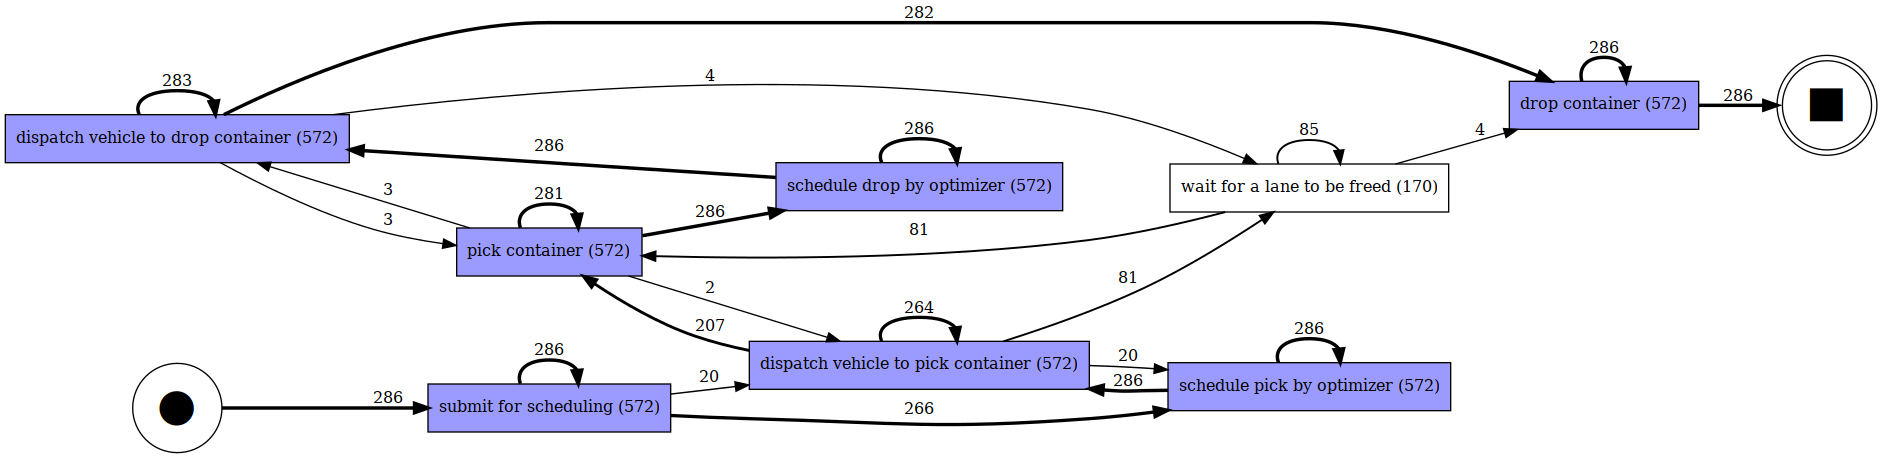

In [122]:
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log_df)
pm4py.view_dfg(dfg, start_activities, end_activities)

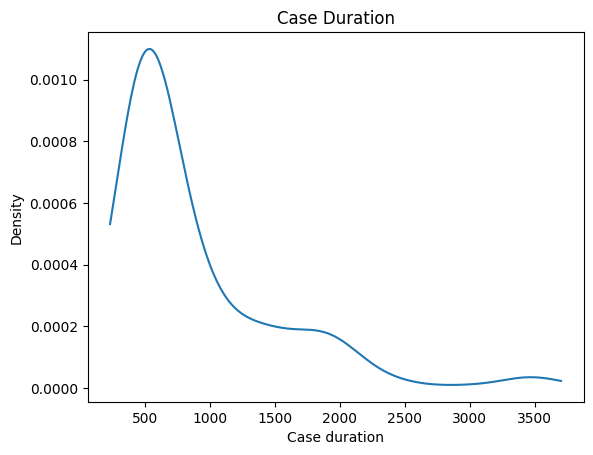

In [105]:
pm4py.view_case_duration_graph(event_log_df)

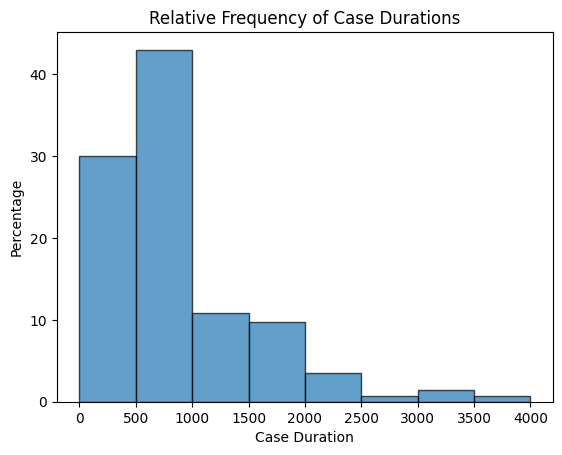

In [120]:
import numpy as np
case_durations = pm4py.get_all_case_durations(event_log_df)
bins = list(range(0, int(np.ceil(max(case_durations) / 500) + 1) * 500, 500))
binned_values = np.digitize(case_durations, bins)
plt.hist(case_durations, bins=bins, weights=np.ones(len(case_durations)) / len(case_durations) * 100, edgecolor='black', alpha=0.7)
plt.xlabel('Case Duration')
plt.ylabel('Percentage')
plt.title('Relative Frequency of Case Durations')
plt.show()

In [129]:
sorted_df = event_log_df.sort_values(by='time:timestamp')

,to_id,case_id,activity,timestamp,lifecycle:transition,org:resource,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp
0,TO_CO_TFTU000001,CO_TFTU000001,submit for scheduling,2024-11-14 10:26:30+00:00,start,SC004,CO_TFTU000001,submit for scheduling,2024-11-14 10:26:30+00:00,0,0,2024-11-14 10:26:30+00:00
406,TO_CO_TFTU000028,CO_TFTU000028,submit for scheduling,2024-11-14 10:26:30+00:00,start,SC006,CO_TFTU000028,submit for scheduling,2024-11-14 10:26:30+00:00,406,27,2024-11-14 10:26:30+00:00
117,TO_CO_TFTU000009,CO_TFTU000009,submit for scheduling,2024-11-14 10:26:30+00:00,complete,SC018,CO_TFTU000009,submit for scheduling,2024-11-14 10:26:30+00:00,117,8,2024-11-14 10:26:30+00:00
116,TO_CO_TFTU000009,CO_TFTU000009,submit for scheduling,2024-11-14 10:26:30+00:00,start,SC018,CO_TFTU000009,submit for scheduling,2024-11-14 10:26:30+00:00,116,8,2024-11-14 10:26:30+00:00
407,TO_CO_TFTU000028,CO_TFTU000028,submit for scheduling,2024-11-14 10:26:30+00:00,complete,SC006,CO_TFTU000028,submit for scheduling,2024-11-14 10:26:30+00:00,407,27,2024-11-14 10:26:30+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3925,TO_CO_TFTU000269,CO_TFTU000269,drop container,2024-11-14 11:39:02+00:00,complete,SC007,CO_TFTU000269,drop container,2024-11-14 11:39:02+00:00,3925,268,2024-11-14 11:39:02+00:00
4101,TO_CO_TFTU000281,CO_TFTU000281,dispatch vehicle to drop container,2024-11-14 11:39:15+00:00,complete,SC019,CO_TFTU000281,dispatch vehicle to drop container,2024-11-14 11:39:15+00:00,4101,280,2024-11-14 11:39:15+00:00
4102,TO_CO_TFTU000281,CO_TFTU000281,drop container,2024-11-14 11:39:16+00:00,start,SC019,CO_TFTU000281,drop container,2024-11-14 11:39:16+00:00,4102,280,2024-11-14 11:39:16+00:00
4159,TO_CO_TFTU000285,CO_TFTU000285,drop container,2024-11-14 11:39:40+00:00,complete,SC016,CO_TFTU000285,drop container,2024-11-14 11:39:40+00:00,4159,284,2024-11-14 11:39:40+00:00


In [167]:
# Note: In our preliminary analysis, we only have one start and one end activity
start_activities = pm4py.get_start_activities(event_log_df)
end_activities = pm4py.get_end_activities(event_log_df)
started_cases = []
running_cases = []
timestamps = []
for idx, row in sorted_df.iterrows():
    case_id = row['case:concept:name']
    activity = row['concept:name']
    timestamp = row['time:timestamp']
    lifecycle_transition = row['lifecycle:transition']
    if row['case:concept:name'] not in started_cases:
        started_cases.append(case_id)
    elif activity in end_activities and lifecycle_transition == 'complete':
        started_cases.remove(case_id)
    
    running_cases.append(len(started_cases))
    timestamps.append(timestamp)


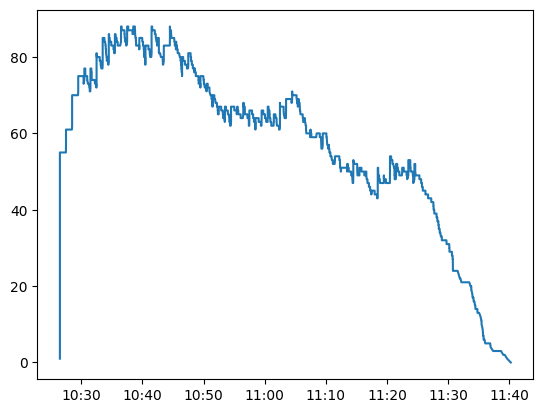

In [168]:
import matplotlib.dates as mdates
plt.plot(timestamps, running_cases)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

### TODOs:

- Analyze space occupation at each location over time
- Analyze vehicles' waiting over time per location

Pipeline Overview:

A vehicle is assigned to a specific container. The vehicle drive from its original location to pick up the container. Once picked up, the container is taken all way to its destination and dropped by the vehicle.

Sometimes, some vehicles have to wait on their way to pick up or drop a container due to the occupation of the lanes by other vehicles